# Modeling

In [1]:
from os import path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool, metrics, cv
from catboost.utils import get_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

plt.style.use('bmh')
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
DATA_DIR = path.join(path.pardir, 'data')
PAN_DIR = path.join(DATA_DIR, 'pangenomes')
FIG_DIR = path.join(path.pardir, 'figs')
MODEL_DIR = path.join(path.pardir, 'models')

In [3]:
antibiotic = 'ethambutol'
threshold = 1e-18

## 1. Preparasi

In [4]:
selected_clusters = {
    'ethambutol': ['rpoB', 'embB', 'group_3642'],
    'isoniazid': ['katG', 'embB', 'group_1325', 'group_3081', 'gidB'],
    'rifampin': ['katG', 'embB', 'rpoB', 'group_1576'],
}


def get_cluster2hash(antibiotic):
    KMERS_HASHES_PATH = path.join(PAN_DIR, antibiotic, 'panfeed1', 'kmers_to_hashes.tsv')
    hashes = pd.read_csv(KMERS_HASHES_PATH, sep='\t')
    return hashes


def get_pyseer(antibiotic):
    PYSEER_PATH = path.join(PAN_DIR, antibiotic, 'pyseer', 'pyseer.tsv')
    pyseer = pd.read_csv(PYSEER_PATH, sep='\t')
    return pyseer


def extract_filtered_kmers(antibiotic, threshold):
    kmers = get_cluster2hash(antibiotic)
    kmers = kmers[kmers.cluster.isin(selected_clusters[antibiotic])]

    pvals = get_pyseer(antibiotic)[['variant', 'filter-pvalue']]
    pvals.columns = ['variant', 'pval']
    pvals = pvals[pvals.pval <= threshold]

    kmers = get_cluster2hash(antibiotic).dropna()
    kmers.columns = ['cluster', 'kmer', 'variant']
    kmers = kmers[kmers.variant.isin(pvals.variant)]
    return kmers


def get_hashes_patterns(antibiotic):
    PATTERN_PATH = path.join(PAN_DIR, antibiotic, 'panfeed1', 'hashes_to_patterns.tsv')
    return pd.read_csv(PATTERN_PATH, sep='\t')


def get_traits(antibiotic):
    TRAITS_PATH = path.join(DATA_DIR, f'traits_{antibiotic}.tsv')
    traits = pd.read_csv(TRAITS_PATH, sep='\t')
    traits.columns = ['id', 'resistance']
    return traits


def get_kmers_matrix(antibiotic, threshold):
    kmers = extract_filtered_kmers(antibiotic, threshold)
    patterns = get_hashes_patterns(antibiotic)

    patterns = patterns[patterns.hashed_pattern.isin(kmers.variant)]

    # Matriks kosong
    M = patterns.copy()[0:0]

    for sample in patterns.iterrows():
        # Ambil Series dari tuple
        sample = sample[1]
    
        for mer in kmers.iterrows():
            # Ambil Series dari tuple
            mer = mer[1]
        
            if sample['hashed_pattern'] == mer['variant']:
                sample_mer = sample.copy()
                sample_mer['hashed_pattern'] = mer['kmer']
                M = pd.concat([M, sample_mer.to_frame().T])

    M = M.rename(columns={'hashed_pattern': 'kmer'})
    M = M.set_index('kmer')
    # Sedikit cek
    assert all(patterns.iloc[0, 1:] == M.iloc[0, :])
    
    M = M.T.reset_index().rename(columns={'index': 'id'})
    M.index.name = None
    M.rename_axis(None, axis=1, inplace=True)
    return M


def get_data(antibiotic, threshold):
    X = get_kmers_matrix(antibiotic, threshold)
    y = get_traits(antibiotic)
    return pd.merge(y, X, how='inner', on='id')

In [5]:
get_data(antibiotic, threshold)

,id,resistance,CATGCCCAGGATGTAGCCGTCGTCCGACGAA,CCATGCCCAGGATGTAGCCGTCGTCCGACGA,CGTCGGACGACGGCTACATCCTGGGCATGGC,GGCCATGCCCAGGATGTAGCCGTCGTCCGAC,GGGCCATGCCCAGGATGTAGCCGTCGTCCGA,CGGACGACGGCTACATCCTGGGCATGGCCCG,GGACGACGGCTACATCCTGGGCATGGCCCGA,CTCGGGCCATGCCCAGGATGTAGCCGTCGTC,...,CGATCACCAGCGGCATCGAGGTCGTATGGAC,CGTCCATACGACCTCGATGCCGCTGGTGATC,ATCACCAGCGGCATCGAGGTCGTATGGACGA,TCACCAGCGGCATCGAGGTCGTATGGACGAA,CACCAGCGGCATCGAGGTCGTATGGACGAAC,ACCAGCGGCATCGAGGTCGTATGGACGAACA,CCAGCGGCATCGAGGTCGTATGGACGAACAC,CAGCGGCATCGAGGTCGTATGGACGAACACC,AGCGGCATCGAGGTCGTATGGACGAACACCC,GCGGCATCGAGGTCGTATGGACGAACACCCC
0,1438835.3.PATRIC,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1438837.3.PATRIC,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1438842.3.PATRIC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,83331.31.PATRIC,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1448833.3.PATRIC,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,1438867.3.PATRIC,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
245,652616.4.PATRIC,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
246,1773.199.PATRIC,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
247,1773.200.PATRIC,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


## 2. Split Train/Test

In [6]:
def split_train_test(data):
    X = data.iloc[:, 2:].to_numpy()
    y = data.iloc[:, 1].to_numpy()
    return train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

In [7]:
data = get_data(antibiotic, threshold)
X_train, X_test, y_train, y_test = split_train_test(data)

for arr in [X_train, X_test, y_train, y_test]:
    print(arr.shape)

(199, 85)
(50, 85)
(199,)
(50,)


## 3. CatBoost

### 3.1 Cross-validation (tanpa _tuning_)

In [8]:
def cv_train(X_train, y_train, antibiotic):
    cat_features = list(range(0, X_train.shape[1]))

    clf = CatBoostClassifier(
        custom_loss=[metrics.AUC()],
        logging_level='Silent',
        random_state=1,
    )

    cv_params = clf.get_params()
    cv_params.update({ 'loss_function': metrics.Logloss()})

    cv_data = cv(
        Pool(X_train, y_train, cat_features=cat_features),
        cv_params,
        plot=True
    )

    print('{} = Best validation AUC score: {:.2f}±{:.2f} on step {}'.format(
        antibiotic.title(),
        np.max(cv_data['test-AUC-mean']),
        cv_data['test-AUC-std'][np.argmax(cv_data['test-AUC-mean'])],
        np.argmax(cv_data['test-AUC-mean'])
    ))

In [9]:
cv_train(X_train, y_train, antibiotic)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Ethambutol = Best validation AUC score: 0.93±0.01 on step 51


### 3.2 Training & Test

In [10]:
def train(X_train, y_train):
    cat_features = list(range(0, X_train.shape[1]))
    clf = CatBoostClassifier(
        custom_loss=[metrics.AUC()],
        logging_level='Silent',
        random_state=1,
    )
    return clf.fit(X_train, y_train, cat_features=cat_features)


def test_auc(clf, X_test, y_test, antibiotic):
    y_pred = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    print(f'{antibiotic.title()}: Skor AUC = %.3f' % auc)
    return auc

In [11]:
clf = train(X_train, y_train)
auc = test_auc(clf, X_test, y_test, antibiotic)

Ethambutol: Skor AUC = 0.946


## 4. Pipeline

### 4.1 Ethambutol

In [12]:
emb = 'ethambutol'

emb_data = get_data(emb, 1e-18)

emb_X_train, emb_X_test, emb_y_train, emb_y_test = split_train_test(emb_data)

cv_train(emb_X_train, emb_y_train, emb)
emb_clf = train(emb_X_train, emb_y_train)

# Simpan model
emb_clf.save_model(path.join(MODEL_DIR, f'{emb}_clf.cbm'), format='cbm')

# Simpan matriks header untuk app
emb_head = emb_data.iloc[0:0, 2:]
emb_head.to_csv(path.join(MODEL_DIR, f'{emb}_matrix_head.tsv'), sep='\t', index=False)
emb_head

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Ethambutol = Best validation AUC score: 0.93±0.01 on step 51


,CATGCCCAGGATGTAGCCGTCGTCCGACGAA,CCATGCCCAGGATGTAGCCGTCGTCCGACGA,CGTCGGACGACGGCTACATCCTGGGCATGGC,GGCCATGCCCAGGATGTAGCCGTCGTCCGAC,GGGCCATGCCCAGGATGTAGCCGTCGTCCGA,CGGACGACGGCTACATCCTGGGCATGGCCCG,GGACGACGGCTACATCCTGGGCATGGCCCGA,CTCGGGCCATGCCCAGGATGTAGCCGTCGTC,ACGACGGCTACATCCTGGGCATGGCCCGAGT,CGACGGCTACATCCTGGGCATGGCCCGAGTC,...,CGATCACCAGCGGCATCGAGGTCGTATGGAC,CGTCCATACGACCTCGATGCCGCTGGTGATC,ATCACCAGCGGCATCGAGGTCGTATGGACGA,TCACCAGCGGCATCGAGGTCGTATGGACGAA,CACCAGCGGCATCGAGGTCGTATGGACGAAC,ACCAGCGGCATCGAGGTCGTATGGACGAACA,CCAGCGGCATCGAGGTCGTATGGACGAACAC,CAGCGGCATCGAGGTCGTATGGACGAACACC,AGCGGCATCGAGGTCGTATGGACGAACACCC,GCGGCATCGAGGTCGTATGGACGAACACCCC


### 4.2 Isoniazid

In [13]:
inh = 'isoniazid'

inh_data = get_data(inh, 1e-18)

inh_X_train, inh_X_test, inh_y_train, inh_y_test = split_train_test(inh_data)

cv_train(inh_X_train, inh_y_train, inh)
inh_clf = train(inh_X_train, inh_y_train)

# Simpan model
inh_clf.save_model(path.join(MODEL_DIR, f'{inh}_clf.cbm'), format='cbm')

# Simpan matriks header untuk app
inh_head = inh_data.iloc[0:0, 2:]
inh_head.to_csv(path.join(MODEL_DIR, f'{inh}_matrix_head.tsv'), sep='\t', index=False)
inh_head

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Isoniazid = Best validation AUC score: 0.96±0.02 on step 53


,AATGGCACGCCCGGCAACCCGGCTCCGCTAC,CAATGGCACGCCCGGCAACCCGGCTCCGCTA,AGCGGAGCCGGGTTGCCGGGCGTGCCATTGG,GCCAATGGCACGCCCGGCAACCCGGCTCCGC,CGCCAATGGCACGCCCGGCAACCCGGCTCCG,GGAGCCGGGTTGCCGGGCGTGCCATTGGCGA,ATCGCCAATGGCACGCCCGGCAACCCGGCTC,AGCCGGGTTGCCGGGCGTGCCATTGGCGATA,CTATCGCCAATGGCACGCCCGGCAACCCGGC,CCGGGTTGCCGGGCGTGCCATTGGCGATAGC,...,CGATCACCACCGGCATCGAGGTCGTATGGAC,CGTCCATACGACCTCGATGCCGGTGGTGATC,ATCACCACCGGCATCGAGGTCGTATGGACGA,TCACCACCGGCATCGAGGTCGTATGGACGAA,CACCACCGGCATCGAGGTCGTATGGACGAAC,ACCACCGGCATCGAGGTCGTATGGACGAACA,CCACCGGCATCGAGGTCGTATGGACGAACAC,CACCGGCATCGAGGTCGTATGGACGAACACC,ACCGGCATCGAGGTCGTATGGACGAACACCC,CCGGCATCGAGGTCGTATGGACGAACACCCC


### 4.3 Rifampin

In [14]:
rif = 'rifampin'

rif_data = get_data(rif, 1e-18)

rif_X_train, rif_X_test, rif_y_train, rif_y_test = split_train_test(rif_data)

cv_train(rif_X_train, rif_y_train, rif)
rif_clf = train(rif_X_train, rif_y_train)

# Simpan model
rif_clf.save_model(path.join(MODEL_DIR, f'{rif}_clf.cbm'), format='cbm')

# Simpan matriks header untuk app
rif_head = rif_data.iloc[0:0, 2:]
rif_head.to_csv(path.join(MODEL_DIR, f'{rif}_matrix_head.tsv'), sep='\t', index=False)
rif_head

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Rifampin = Best validation AUC score: 0.98±0.01 on step 19


,CAGCGGGTTGTTCTGGTCCATGAATTGGCTC,ACAGCGGGTTGTTCTGGTCCATGAATTGGCT,GACAGCGGGTTGTTCTGGTCCATGAATTGGC,CCAATTCATGGACCAGAACAACCCGCTGTCG,CAATTCATGGACCAGAACAACCCGCTGTCGG,AATTCATGGACCAGAACAACCCGCTGTCGGG,ATTCATGGACCAGAACAACCCGCTGTCGGGG,ACCCCGACAGCGGGTTGTTCTGGTCCATGAA,AACCCCGACAGCGGGTTGTTCTGGTCCATGA,CAACCCCGACAGCGGGTTGTTCTGGTCCATG,...,CCTGGGCATGGCCCGAGTCGCCGACCACGCC,CGGCGTGGTCGGCGACTCGGGCCATGCCCAG,CCGGCGTGGTCGGCGACTCGGGCCATGCCCA,GCCGGCGTGGTCGGCGACTCGGGCCATGCCC,AGCCGGCGTGGTCGGCGACTCGGGCCATGCC,GCATGGCCCGAGTCGCCGACCACGCCGGCTA,CATGGCCCGAGTCGCCGACCACGCCGGCTAC,ATGGCCCGAGTCGCCGACCACGCCGGCTACA,ATGTAGCCGGCGTGGTCGGCGACTCGGGCCA,CATGTAGCCGGCGTGGTCGGCGACTCGGGCC


### 4.4 Evaluasi total

Ethambutol: Skor AUC = 0.946
Isoniazid: Skor AUC = 0.942
Rifampin: Skor AUC = 0.942


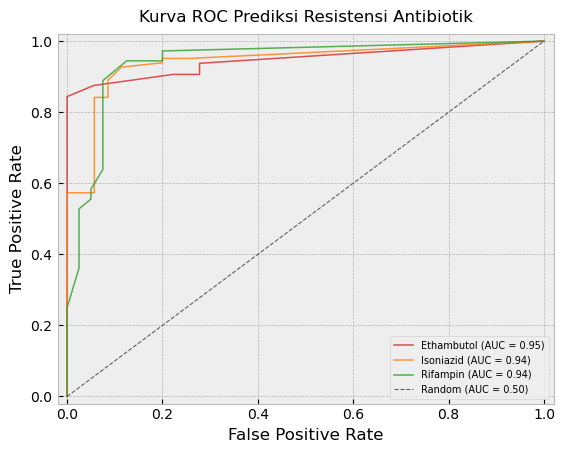

In [15]:
def plot_roc(clf, X_test, y_test, antibiotic, color):
    y_pred = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    
    plt.plot(
        fpr, tpr, 
        color=color, 
        linestyle='solid', 
        lw=1.1,
        alpha=0.8,
        label=f'{antibiotic.title()} (AUC = {test_auc(clf, X_test, y_test, antibiotic):.2f})'
    )


plot_roc(emb_clf, emb_X_test, emb_y_test, emb, 'tab:red')
plot_roc(inh_clf, inh_X_test, inh_y_test, inh, 'tab:orange')
plot_roc(rif_clf, rif_X_test, rif_y_test, rif, 'tab:green')

plt.plot(
    [0, 1], [0, 1], 
    color='black', 
    lw=0.8, 
    linestyle='dashed', 
    alpha=0.6, 
    label='Random (AUC = 0.50)'
)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Kurva ROC Prediksi Resistensi Antibiotik', y=1.01, size='large')
plt.legend(loc='lower right', prop={'size': 7})

plt.savefig(path.join(FIG_DIR, 'roc.png'), format='png', dpi=600, bbox_inches='tight')
plt.show()